# Hierarchical Window Clustering Approach to detecting Spiking Motifs 

### Sparse method

## Data Generation

In [28]:
'''
Model parameters
'''
import random
import numpy as np

M = 4 # Number of Spiking motifs
N = 60 # Number of input neurons
D = 31 # temporal depth of receptive field
T = 4000
dt = 1
nrn_fr = 20 # hz
pg_fr = 4 # hz
background_noise_fr = 10 # h


np.random.seed(42)

In [29]:
'''
Setup
'''

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import sys
np.set_printoptions(threshold=sys.maxsize)
disp_figs = True
import colorsys

def create_color_spectrum(num_labels):
    golden_ratio_conjugate = 0.618033988749895
    hues = np.arange(num_labels)
    hues = (hues * golden_ratio_conjugate) % 1.0
    saturations = np.ones(num_labels) * 0.8
    lightness = np.ones(num_labels) * 0.6

    # Convert HSL to RGB and then to hexadecimal
    colors = []
    for h, s, l in zip(hues, saturations, lightness):
        r, g, b = [int(255 * x) for x in colorsys.hls_to_rgb(h, l, s)]
        colors.append(f'#{r:02x}{g:02x}{b:02x}')

    return colors

# Existing colors represented as hexadecimal strings
existing_colors = np.array(['#000000','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Create a palette with 101 colors (11 existing + 90 new)
num_new_colors = 90
new_colors = create_color_spectrum(num_new_colors)
palette = np.concatenate([existing_colors, new_colors])

In [30]:
'''
Synthetic Data Generation
'''
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.rand(N,D,M)*1000
K_dense = (K_dense < nrn_fr).astype('int')
K_sparse = np.where(K_dense)
K_sparse = (K_sparse[0],K_sparse[1],K_sparse[2]+1)

# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.rand(M,T)*1000
B_dense = (B_dense < pg_fr).astype('int')
B_sparse = np.where(B_dense)
B_sparse = (B_sparse[0]+1,B_sparse[1])# This way the first motif starts at index 1 instead of index 0

# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,0] = np.random.rand(N,T+D)*1000
A_dense[...,0] = (A_dense[...,0] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b-1]
    
A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1

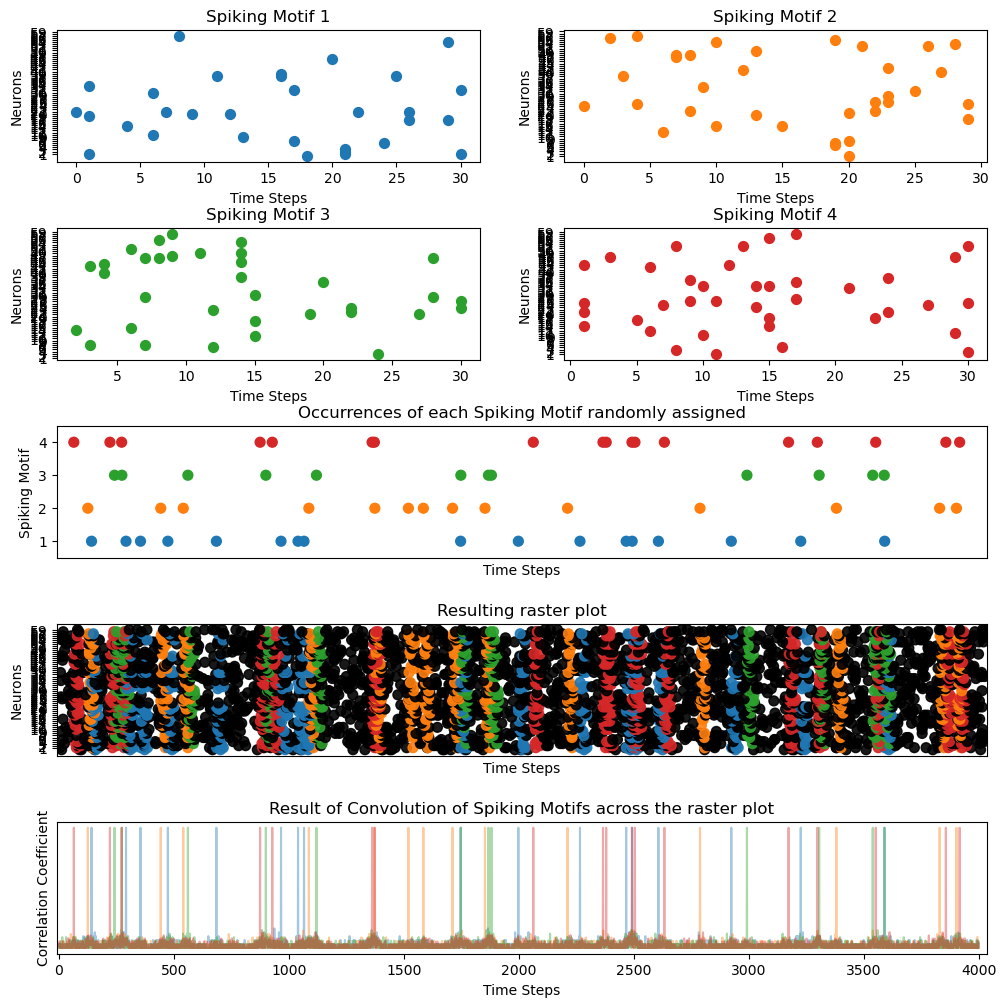

In [31]:
import matplotlib.ticker as ticker

fig, ax = plt.subplot_mosaic('AB;CD;EE;FF;GG', figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1, 1, 1, 1]})

s = 50

# Scatter plots for A, B, C, D
for i, k in enumerate(['A', 'B', 'C', 'D']):
    ax[k].scatter(K_sparse[1][K_sparse[2] == i+1], K_sparse[0][K_sparse[2] == i+1], c=palette[i+1], s=s)
    ax[k].set_title(f'Spiking Motif {i + 1}')  # Updated title for plots A, B, C, D
    ax[k].set_xlabel('Time Steps')
    ax[k].set_ylabel('Neurons')
    ax[k].set_yticks(range(1, N))

spiking_motif_data = [B_sparse[0][B_sparse[1] == i+1] for i in range(4)]  # Collect data for each Spiking Motif
ax['E'].scatter(B_sparse[1], B_sparse[0]-1, c=palette[B_sparse[0]], s=s)
ax['E'].set_title('Occurrences of each Spiking Motif randomly assigned')
ax['E'].set_xlabel('Time Steps')
ax['E'].set_ylabel('Spiking Motif')  # Updated y-axis label for plot E

# Set y-axis ticks and labels explicitly for Spiking Motifs 1 to 4
ax['E'].set_yticks(range(0, M))  # Set y-axis ticks for plot E to represent the four Spiking Motifs
ax['E'].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x) + 1}'))  # Map y-axis labels to display 1 through 4
ax['E'].set_ylim(-0.5, 3.5)  # Set y-axis limits to display only the ticks and labels for the existing values


# Scatter plot for F
ax['F'].scatter(A_sparse[1], A_sparse[0], c=palette[A_sparse[2]], alpha=0.9, s=s*4, marker='.')
ax['F'].set_title('Resulting raster plot')
ax['F'].set_xlabel('Time Steps')
ax['F'].set_ylabel('Neurons')  # Y-axis represents neurons, no need to update y-axis label
ax['F'].set_yticks(range(1, N))  # Set y-axis ticks for plot F to represent neurons

sanity_check = np.zeros((T,M))
for j in range(M):
    for i in range(T):
        sanity_check[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

# Plot for G
[ax['G'].plot(sanity_check[:, i], color=palette[i+1], alpha=0.4) for i in range(M)]
ax['G'].set_title('Result of Convolution of Spiking Motifs across the raster plot')
ax['G'].set_xlabel('Time Steps')
ax['G'].set_ylabel('Correlation Coefficient')  # Updated y-axis label for plot G
ax['G'].set_yticks([])  # Remove y-axis ticks for plot G

# Set common x-axis from 0 to 1000 with padding
common_xlim = (min(A_sparse[1]), max(A_sparse[1]))
padding = 10
ax['E'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)
ax['F'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)
ax['G'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)

# Share x-axis for E, F, and G
ax['E'].sharex(ax['F'])
ax['G'].sharex(ax['F'])

# Hide x-axis ticks and labels for E and F
ax['E'].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax['F'].tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

plt.show()


In [32]:
[K_sparse[0][K_sparse[2] == i+1] for i in range(4)]

[array([ 0,  1,  1,  1,  2,  3,  6,  7,  9, 10, 14, 17, 17, 19, 20, 20, 21,
        21, 21, 21, 30, 31, 31, 33, 38, 38, 38, 39, 46, 54, 57],
       dtype=int64),
 array([ 1,  6,  7,  8, 12, 15, 15, 18, 20, 21, 22, 22, 24, 25, 25, 26, 26,
        29, 31, 33, 38, 40, 41, 42, 47, 48, 48, 50, 52, 52, 53, 54, 55, 56,
        57], dtype=int64),
 array([ 3,  6,  7,  7, 11, 14, 15, 18, 21, 21, 22, 23, 24, 24, 27, 29, 29,
        30, 36, 38, 40, 43, 44, 45, 47, 47, 47, 48, 49, 49, 51, 54, 55, 58],
       dtype=int64),
 array([ 1,  2,  3,  4, 10, 11, 12, 14, 14, 17, 18, 18, 21, 21, 23, 24, 24,
        25, 25, 26, 26, 27, 32, 33, 33, 33, 35, 36, 37, 42, 43, 43, 47, 47,
        52, 52, 52, 56, 58], dtype=int64)]

# Test

In [33]:
# Windowing the data
window_dim = int(D*2) # choosing a window to surround the spikes, this is a prediction but for now we will use the a priori depth D
N_labels = A_sparse[0].copy()
T_labels = A_sparse[1].copy()

In [34]:
import HDP_detect
pattern_template, sublist_keys_filt = HDP_detect.scan_raster(T_labels, N_labels, window_dim = None)

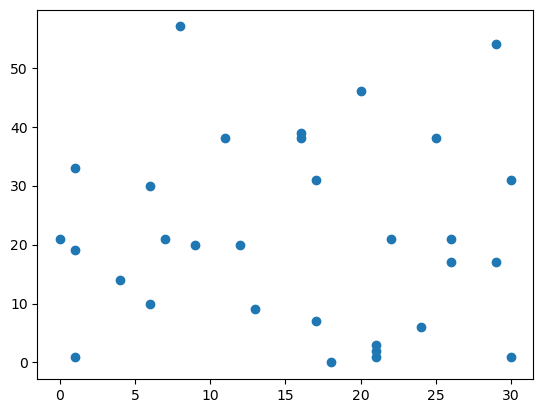

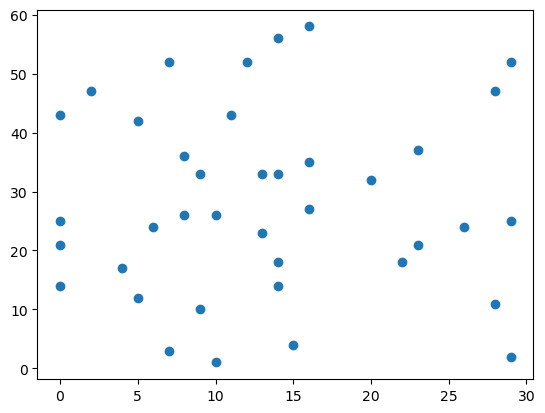

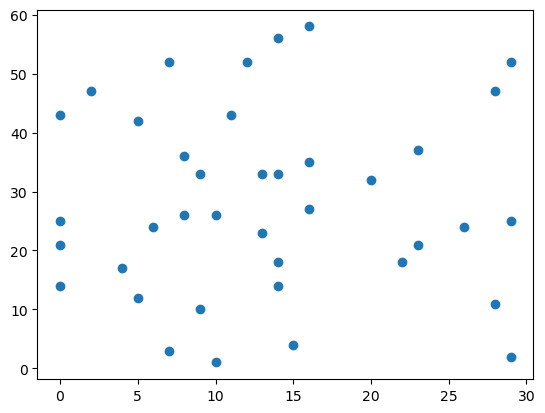

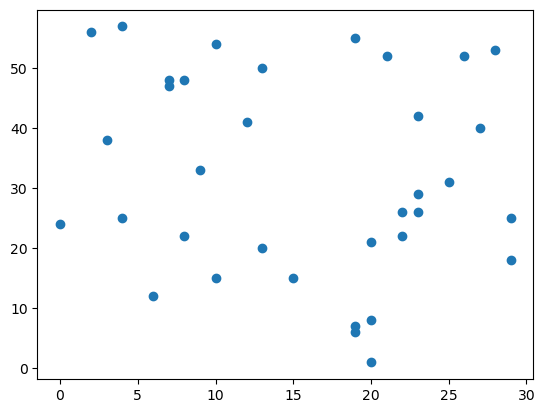

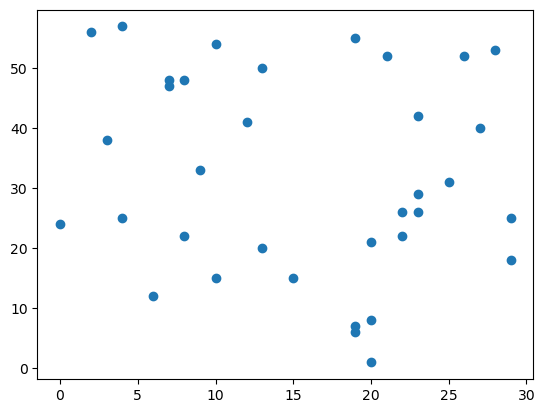

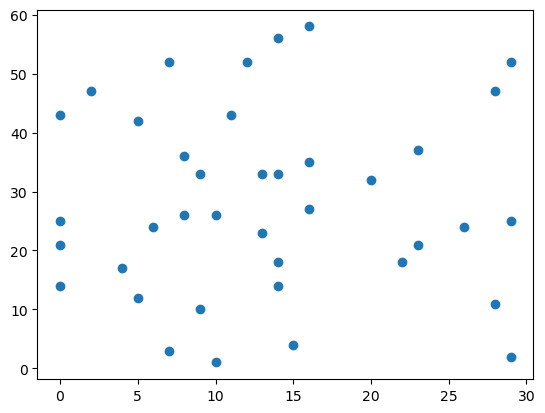

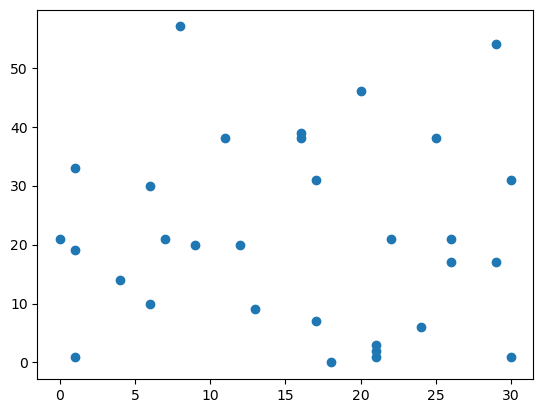

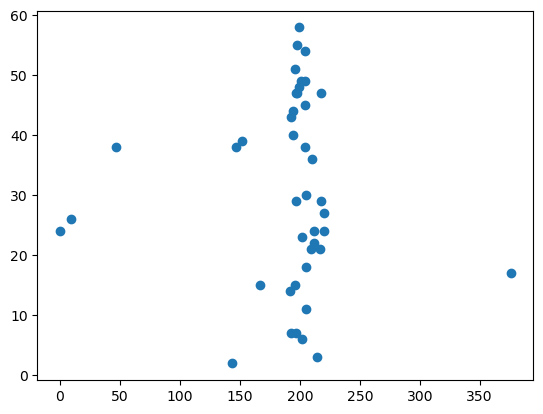

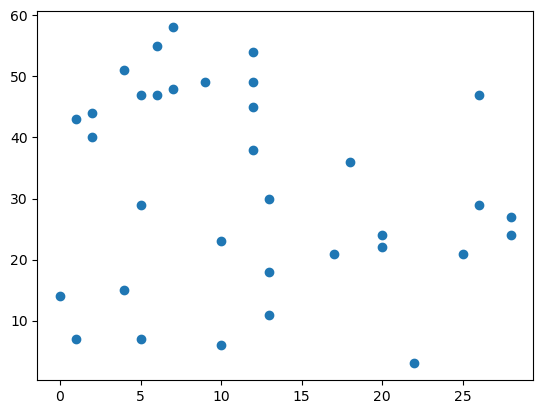

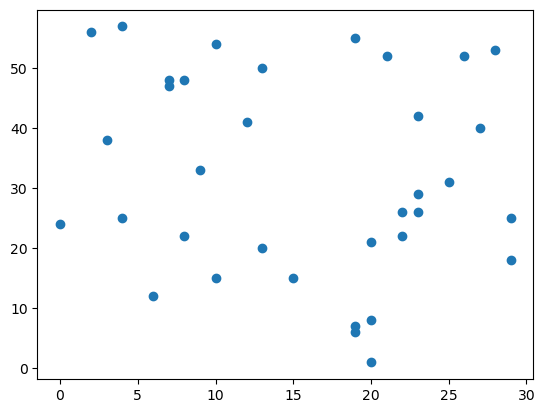

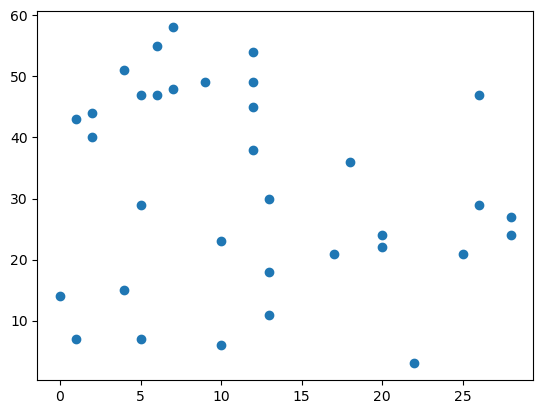

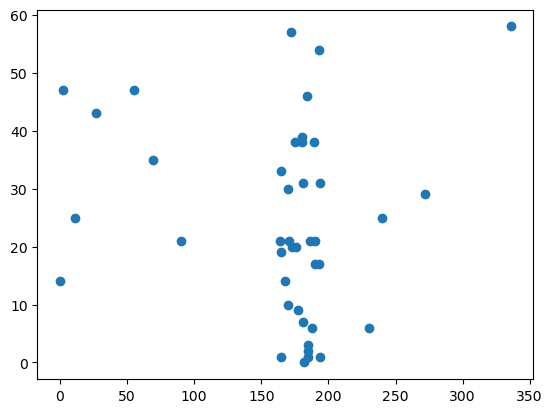

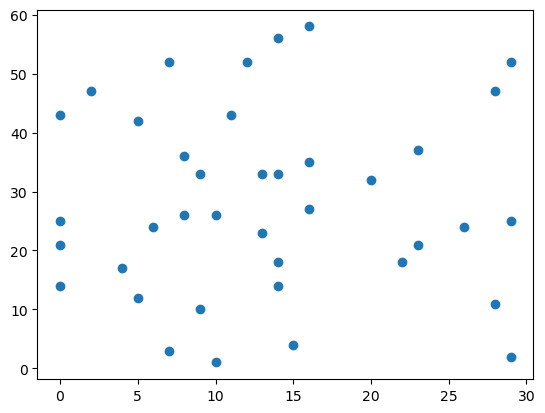

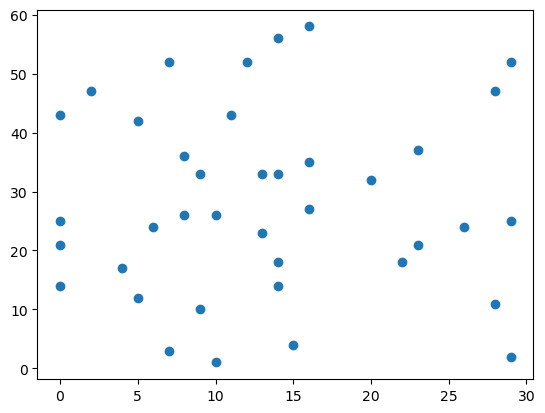

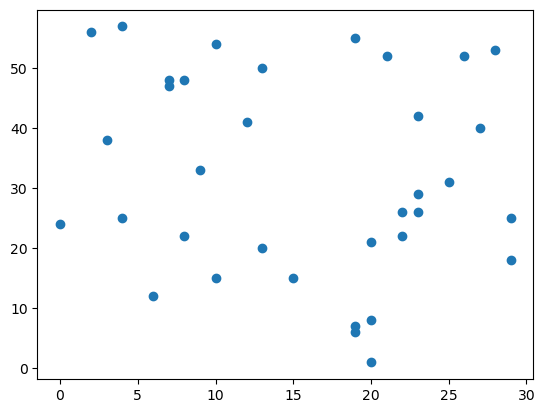

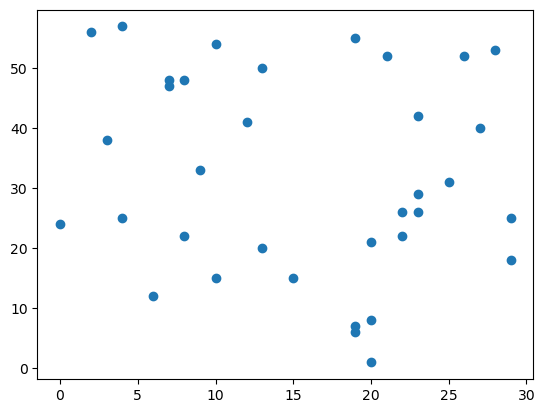

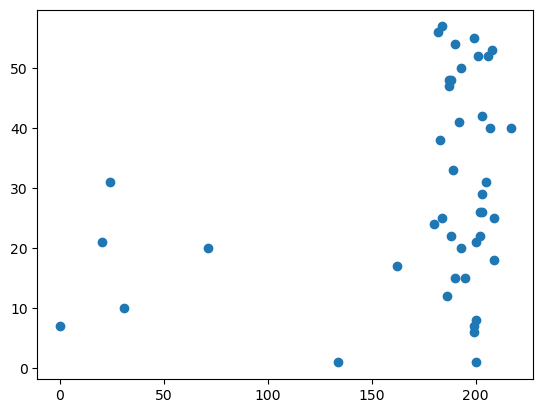

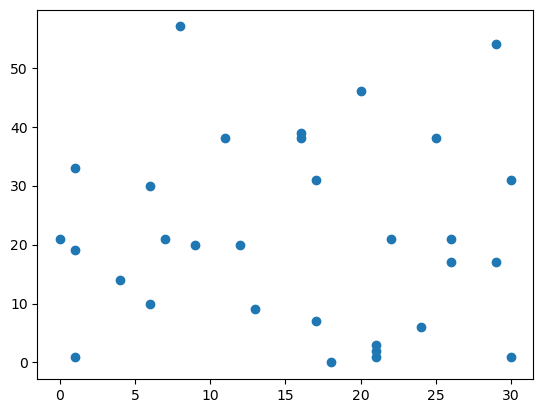

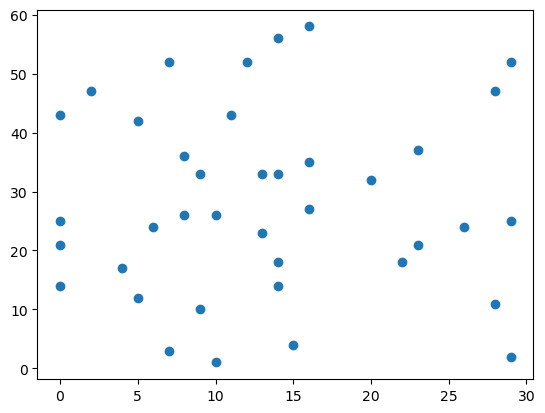

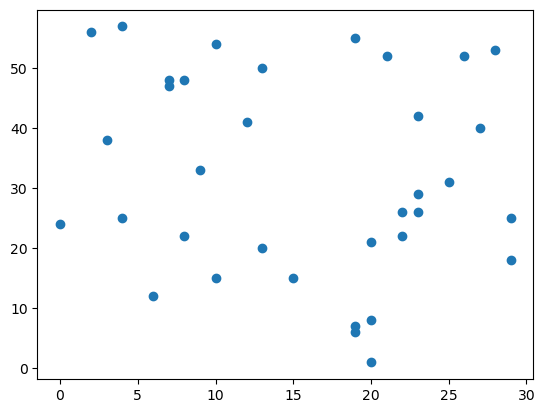

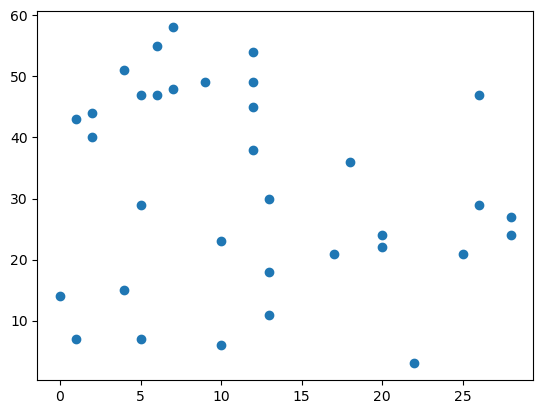

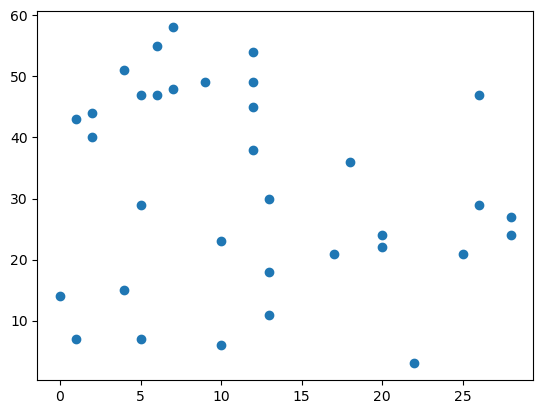

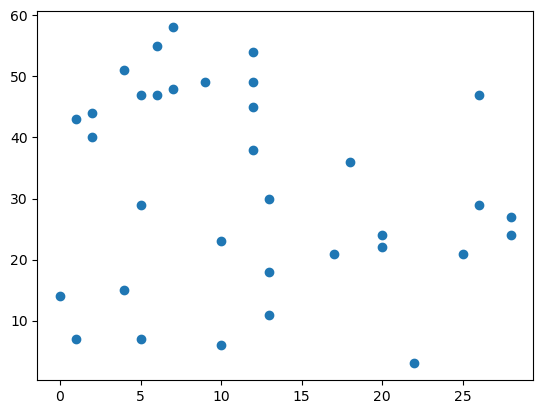

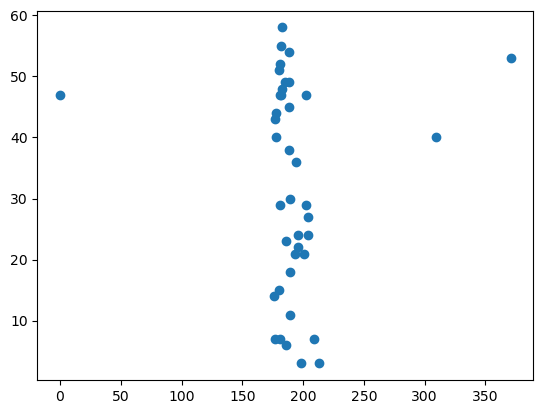

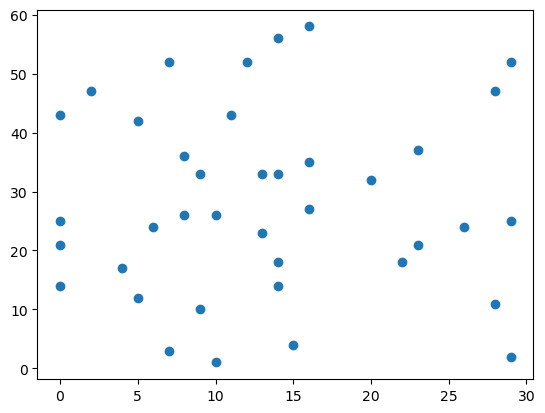

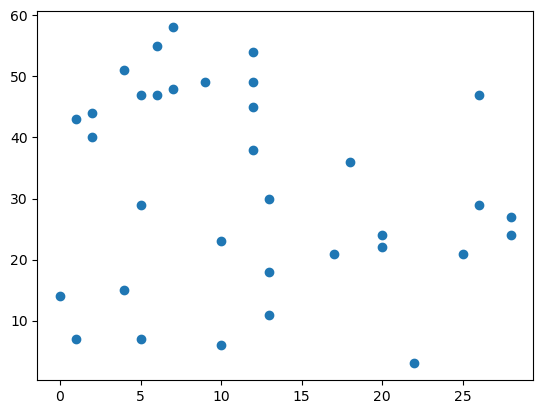

In [35]:
for pattern in pattern_template:
    plt.figure()
    plt.scatter(*pattern.T)
    plt.show()